# 🧠 Predição de Progressão da Doença com Random Forest (Diabetes Dataset)

Este projeto utiliza o dataset clássico de **Diabetes** da biblioteca `scikit-learn` para prever a progressão da doença com base em medidas clínicas e laboratoriais. O modelo escolhido foi o **Random Forest Regressor**, utilizando engenharia de atributos, detecção de outliers, validação cruzada e ajuste de hiperparâmetros com `GridSearchCV`.

---

## 🎯 Objetivo

Prever os valores contínuos do alvo (`target`), que representam a progressão da diabetes, com base nas 10 variáveis clínicas fornecidas.

---

## 🗂️ Estrutura do Código

- 🔍 **Análise exploratória** (EDA)
- 📊 **Mapa de correlação e boxplots**
- 📈 **Engenharia de atributos**
- 🧼 **Detecção e contagem de outliers com Z-score**
- ✂️ **Seleção de variáveis relevantes com Random Forest**
- 🔧 **Ajuste fino de hiperparâmetros com validação cruzada**
- 🧠 **Treinamento final do modelo**
- 🧪 **Avaliação com métricas: RMSE, MAE, R²**
- 📉 **Visualizações: resíduos, dispersão real x predito, curva ordenada**

---

## 🔢 Dados

Dataset disponível no `scikit-learn`: `load_diabetes(as_frame=True)`

- **Features (10)**: idade, sexo, IMC, pressão arterial, e 6 medições bioquímicas padronizadas (`s1` a `s6`).
- **Target**: Medida quantitativa da progressão da doença.

---

## 🔨 Pré-Processamento

- **Verificação de valores nulos**
- **Boxplot para detecção visual de outliers**
- **Z-score** para identificar registros fora do padrão
- **Engenharia de atributos** adicionando interações e transformações:
  - `bmi_s5` = `bmi` * `s5`
  - `bp_s4` = `bp` * `s4`
  - `bmi_squared` = `bmi²`
  - `s5_log` = `log(|s5| + 1)`

---

## ✂️ Seleção de Variáveis

1. Filtro inicial com base na **correlação com o target** (|cor| > 0.1)
2. Filtro adicional com base na **importância de variáveis** do Random Forest (`feature_importances_ > 0.02`)

---

## ⚙️ Treinamento do Modelo

- **Algoritmo**: `RandomForestRegressor`
- **GridSearchCV**:
  - `n_estimators`: [100, 200, 300]
  - `max_depth`: [3, 5, 7, 10]
  - `min_samples_split`: [5, 10, 20]
  - `min_samples_leaf`: [1, 2, 4]
  - `max_features`: ['sqrt', 'log2']
- **Validação**: `KFold(n_splits=10, shuffle=True, random_state=42)`

---

## 📈 Avaliação do Modelo

- **Métricas calculadas**:
  - `RMSE (Treino/Teste)`
  - `MAE (Teste)`
  - `R² (Teste)`
  - `R² Médio (CV)`

---

## 📊 Visualizações

- **Gráfico 1**: Dispersão de `Valor Real` vs `Valor Predito`
- **Gráfico 2**: Distribuição dos resíduos com linha de média
- **Gráfico 3**: Comparação ordenada entre valores reais e preditos

---


## 💡 Conclusão

Este projeto mostrou uma abordagem robusta de aprendizado supervisionado com regressão usando Random Forest, com destaque para:

- Engenharia de atributos
- Seleção inteligente de variáveis
- Validação cruzada com GridSearch
- Visualizações interpretáveis

O desempenho final depende da qualidade dos dados e da variabilidade natural do problema. Este pipeline serve como base sólida para projetos preditivos similares com dados tabulares.

---


In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import KFold

from scipy.stats import zscore
import numpy as np
import pandas as pd

In [2]:
# 🔢 Carregando o dataset
dados = load_diabetes(as_frame=True)
X = dados.data
y = dados.target
df = dados.frame.copy()

# 📦 Data Preparation
print("\n📌 VISÃO GERAL DO DATASET:\n")
print(df.head())

print("\n📌 INFO:\n")
print(df.info())

print("\n📌 DESCRIÇÃO ESTATÍSTICA:\n")
print(df.describe())

print("\n📌 VALORES AUSENTES:\n")
print(df.isnull().sum())

print("\n📌 CORRELAÇÃO COM O TARGET:\n")
correlacoes = df.corr()["target"].sort_values(ascending=False)
print(correlacoes)


📌 VISÃO GERAL DO DATASET:

        age       sex       bmi        bp        s1        s2        s3  \
0  0.038076  0.050680  0.061696  0.021872 -0.044223 -0.034821 -0.043401   
1 -0.001882 -0.044642 -0.051474 -0.026328 -0.008449 -0.019163  0.074412   
2  0.085299  0.050680  0.044451 -0.005670 -0.045599 -0.034194 -0.032356   
3 -0.089063 -0.044642 -0.011595 -0.036656  0.012191  0.024991 -0.036038   
4  0.005383 -0.044642 -0.036385  0.021872  0.003935  0.015596  0.008142   

         s4        s5        s6  target  
0 -0.002592  0.019907 -0.017646   151.0  
1 -0.039493 -0.068332 -0.092204    75.0  
2 -0.002592  0.002861 -0.025930   141.0  
3  0.034309  0.022688 -0.009362   206.0  
4 -0.002592 -0.031988 -0.046641   135.0  

📌 INFO:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 442 entries, 0 to 441
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   age     442 non-null    float64
 1   sex     442 non-null    float64
 2   b

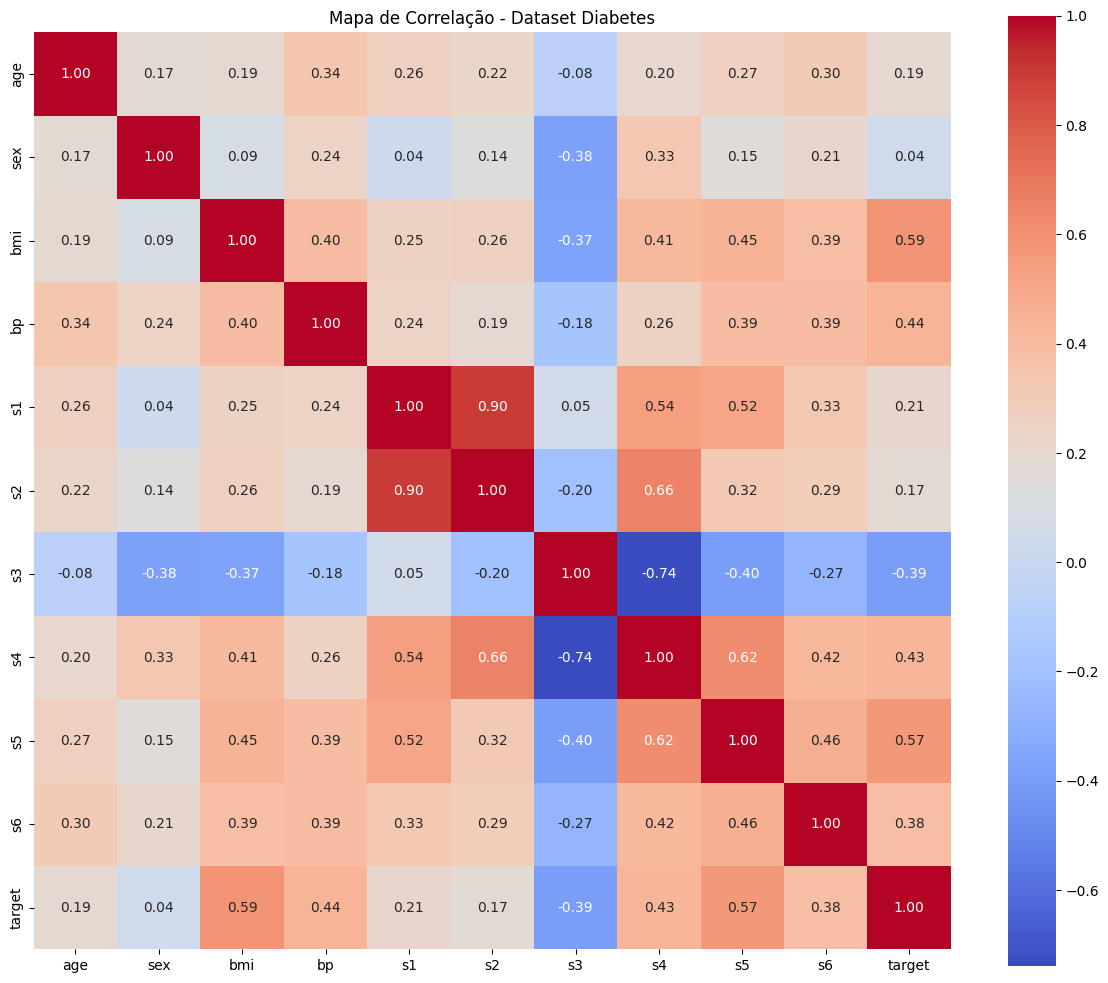

In [3]:
# 📊 Heatmap de correlação
plt.figure(figsize=(12, 10))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt=".2f", square=True)
plt.title("Mapa de Correlação - Dataset Diabetes")
plt.tight_layout()
plt.show()

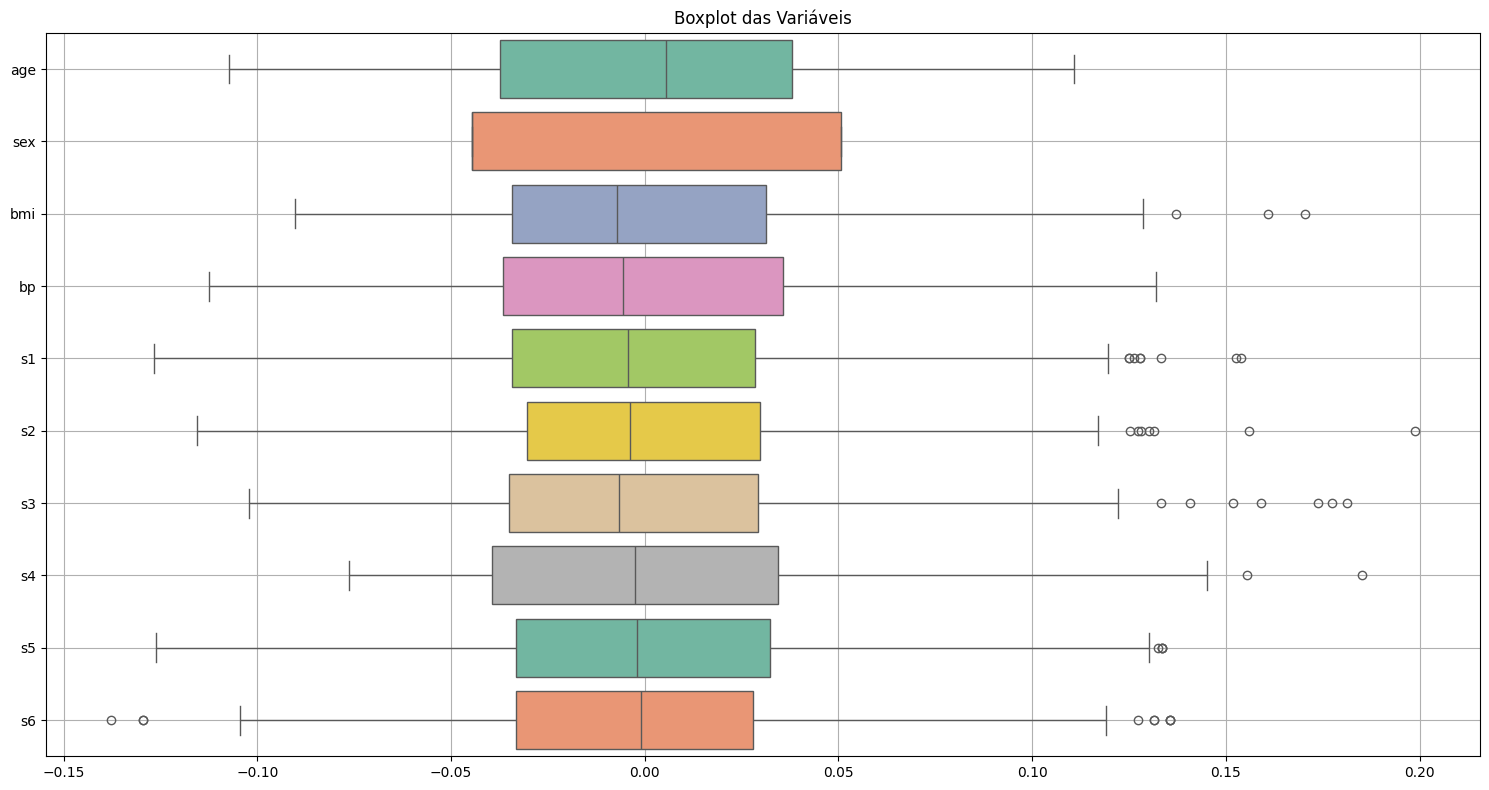

In [4]:
plt.figure(figsize=(15, 8))
sns.boxplot(data=X, orient="h", palette="Set2")
plt.title("Boxplot das Variáveis")
plt.grid(True)
plt.tight_layout()
plt.show()

In [5]:
# Calcula o z-score para todo o X
z_scores = np.abs(zscore(X))
outliers = (z_scores > 3)

# Quantos outliers por variável
outliers_por_variavel = outliers.sum(axis=0)
print("Nº de possíveis outliers por variável:")
print(pd.Series(outliers_por_variavel, index=X.columns))

# Quantos registros têm pelo menos 1 outlier
print("\nTotal de registros com pelo menos um valor fora do padrão:", outliers.any(axis=1).sum())


Nº de possíveis outliers por variável:
age    0
sex    0
bmi    2
bp     0
s1     2
s2     2
s3     5
s4     4
s5     0
s6     0
dtype: int64

Total de registros com pelo menos um valor fora do padrão: 12


In [6]:
# 🧠 Engenharia de atributos com base em variáveis mais correlacionadas
X["bmi_s5"] = X["bmi"] * X["s5"]
X["bp_s4"] = X["bp"] * X["s4"]
X["bmi_squared"] = X["bmi"] ** 2
X["s5_log"] = np.log1p(np.abs(X["s5"]))

# 🧼 Seleção inicial de variáveis com correlação > 0.1 com o target
correlacoes = df.corr()["target"].abs()
variaveis_correlacionadas = correlacoes[correlacoes > 0.1].index.tolist()
variaveis_correlacionadas.remove("target")


In [7]:
# Combina com atributos novos
X = X[variaveis_correlacionadas + ["bmi_s5", "bp_s4", "bmi_squared", "s5_log"]]

# 🔀 Split (DEPOIS da engenharia e seleção inicial)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 📊 Seleção de variáveis com modelo simples
modelo_temp = RandomForestRegressor(n_estimators=100, random_state=42)
modelo_temp.fit(X_train, y_train)
importancias = pd.Series(modelo_temp.feature_importances_, index=X_train.columns)
variaveis_relevantes = importancias[importancias > 0.03].index.tolist()


In [8]:
# Atualiza os dados com base nas variáveis relevantes
X_train = X_train[variaveis_relevantes]
X_test = X_test[variaveis_relevantes]

In [9]:
modelo_temp = RandomForestRegressor(n_estimators=100, random_state=42)
modelo_temp.fit(X_train, y_train)

importancias = pd.Series(modelo_temp.feature_importances_, index=X_train.columns)
variaveis_relevantes = importancias[importancias > 0.02].index.tolist()

# Atualiza X com as variáveis relevantes selecionadas
X = X[variaveis_relevantes]

In [10]:
# 🔧 GridSearch com validação cruzada robusta
param_grid = {
    "n_estimators": [100, 200, 300],
    "max_depth": [3, 5, 7, 10],
    "min_samples_split": [5, 10, 20],
    "min_samples_leaf": [1, 2, 4],
    "max_features": ["sqrt", "log2"]
}

modelo_base = RandomForestRegressor(random_state=42)
grid = GridSearchCV(modelo_base, param_grid, cv = KFold(n_splits=10, shuffle=True, random_state=42), scoring="r2", n_jobs=-1)
grid.fit(X_train, y_train)
melhor_modelo = grid.best_estimator_

In [11]:
# 🔮 Previsões
y_pred_train = melhor_modelo.predict(X_train)
y_pred_test = melhor_modelo.predict(X_test)

# 📏 Avaliação
rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
mae_test = mean_absolute_error(y_test, y_pred_test)
r2_test = r2_score(y_test, y_pred_test)
cv_r2 = cross_val_score(melhor_modelo, X_train, y_train, cv=5, scoring="r2").mean()

In [12]:
# 📊 Métricas
print(f"\n🏆 Melhor combinação de parâmetros: {grid.best_params_}")
print(f"✅ RMSE (Treino): {rmse_train:.2f}")
print(f"✅ RMSE (Teste): {rmse_test:.2f}")
print(f"✅ MAE  (Teste): {mae_test:.2f}")
print(f"✅ R²   (Teste): {r2_test:.2f}")
print(f"📉 R² Médio (CV Treino): {cv_r2:.2f}")


🏆 Melhor combinação de parâmetros: {'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}
✅ RMSE (Treino): 43.21
✅ RMSE (Teste): 54.62
✅ MAE  (Teste): 45.15
✅ R²   (Teste): 0.44
📉 R² Médio (CV Treino): 0.42


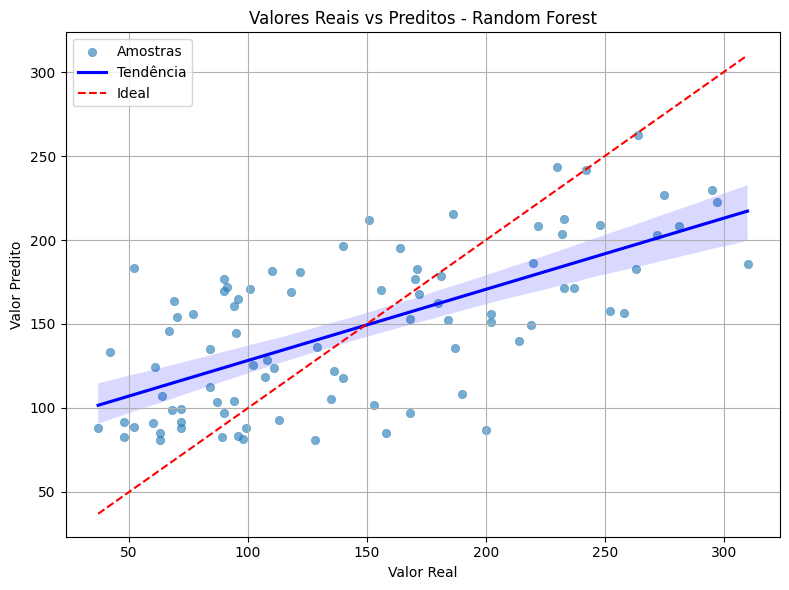

In [13]:
# 📈 Gráfico 1: Dispersão Real vs Predito com linha de tendência
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred_test, alpha=0.6, edgecolor=None, label="Amostras")
sns.regplot(x=y_test, y=y_pred_test, scatter=False, color='blue', label='Tendência')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label='Ideal')
plt.xlabel("Valor Real")
plt.ylabel("Valor Predito")
plt.title("Valores Reais vs Preditos - Random Forest")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

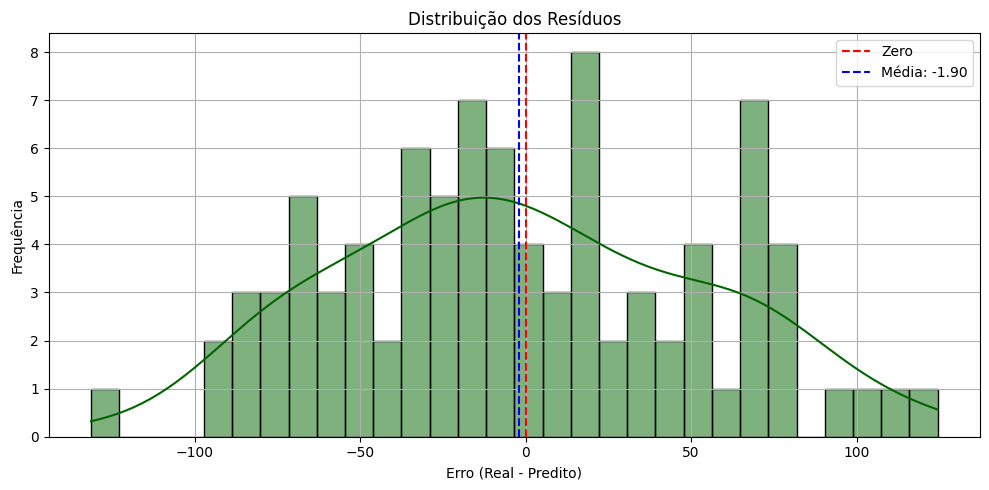

In [14]:
# 📉 Gráfico 2: Distribuição dos Resíduos
residuos = y_test - y_pred_test
media_residuo = residuos.mean()

plt.figure(figsize=(10, 5))
sns.histplot(residuos, kde=True, bins=30, color='darkgreen')
plt.axvline(0, color='red', linestyle='--', label='Zero')
plt.axvline(media_residuo, color='blue', linestyle='--', label=f'Média: {media_residuo:.2f}')
plt.title("Distribuição dos Resíduos")
plt.xlabel("Erro (Real - Predito)")
plt.ylabel("Frequência")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

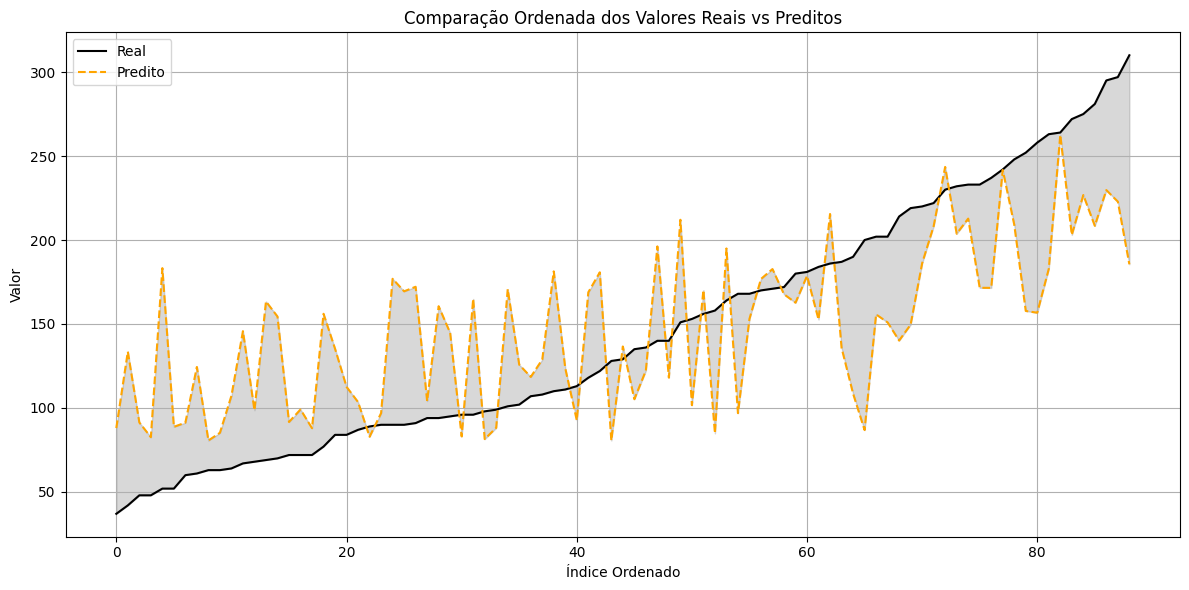

In [15]:
# 📈 Gráfico 3: Comparação ordenada Real vs Predito
df_resultado = pd.DataFrame({"Real": y_test, "Predito": y_pred_test}).sort_values(by="Real").reset_index(drop=True)

plt.figure(figsize=(12, 6))
plt.plot(df_resultado["Real"], label="Real", color="black")
plt.plot(df_resultado["Predito"], label="Predito", color="orange", linestyle="--")
plt.fill_between(df_resultado.index, df_resultado["Real"], df_resultado["Predito"], color='gray', alpha=0.3)
plt.xlabel("Índice Ordenado")
plt.ylabel("Valor")
plt.title("Comparação Ordenada dos Valores Reais vs Preditos")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()